## Libraries

In [1]:
import geopandas as gpd
import shapely
from shapely.geometry import box, LineString, Point,MultiPoint
from shapely.ops import nearest_points
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import networkx as nx
import re
import itertools

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


At each step (i.e. with the creation of each unimodal network), need to keep track of two things: <br>
1. link IDs for each link
1. the network topology, so which two nodes are connected by the link ID

In [2]:
string = 'bs1'
re.sub('\D', '', string)

'1'

## Helper functions

In [3]:
# nodes_type_list is list of tuples of form [(nodes_df, node_color, node_label)]
def plot_nodes_and_edges(node_type_list, edges_df):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    edges_df.plot(ax=ax, color = 'darkgray', zorder=1, label='edges')
    for n in node_type_list:
        n[0].plot(ax=ax, color = n[1], label = n[2], zorder=2)
    ax.legend()
    return ax

In [4]:
# add a column for the node's position in the form used by networkx. 
# note: this is only useful when converting from geopandas df to networkx graph
def nx_pos(x, y):
    return {'pos': (x,y)}

In [5]:
# convert from gpd df to networkx graph object
# input: df of nodes
# output: networkx graph with nodes and positions. note: edges still need to be added to complete the graph structure
def to_nx_graph(nodes_df):
    graph_nodes = list(zip(nodes_df.ID.tolist(), nodes_df.nx_pos.tolist()))
    G = nx.DiGraph()
    G.add_nodes_from(graph_nodes)
    return G

In [6]:
# prune the edges of the edge df
# eliminates edges that connect nodes which are not members of the graph
# return graph edges in the proper form, ready to be added to the networkx graph
def prune_edges(G, edges_df):
    edges_df_subset = edges_df[(edges_df['N1'].isin(G.nodes)) & (edges_df['N2'].isin(G.nodes))]
    graph_edges = list(zip(edges_df_subset['N1'].tolist(), edges_df_subset['N2'].tolist(),
                       edges_df_subset['attr'].tolist()))
    return graph_edges

In [7]:
def nx_edge_attr(linkID, speed):
    attr_dict = {'linkID': linkID, 'speed':speed}
    return attr_dict

In [8]:
def nx_edge_attr(attr_name, attr_var):
    return {attr_name: attr_var}

In [9]:
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [10]:
def rename_nodes(G, prefix):
    re.sub('\D', '', string)
    new_nodename = [prefix + re.sub('\D', '', str(i)) for i in G.nodes]
    namemap = dict(zip(G.nodes, new_nodename))
    G = nx.relabel_nodes(G, namemap, True)
    return G

In [11]:
# https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas
# input: single point, multipoint (collection of many nodes)
# output: the node in multipoint that is nearest to the input single point
def near(input_point, base_nodes_df):
    multipoint = base_nodes_df.geometry.unary_union
    nn_geom = nearest_points(input_point, multipoint)[1]  # returns the nn point as a geometry
    dist = input_point.distance(nn_geom)  # nearest neighbor distance 
    # find the ID (w.r.t the base network) of the nearest neighbor 
    idx = base_nodes_df['geometry'] == nn_geom
    nn_ID = base_nodes_df[idx]['ID'].to_numpy()[0]
    return (nn_geom, nn_ID, dist)

In [12]:
def draw_graph(G, node_color, node_cmap, edge_color):
    # draw the graph in networkx
    node_coords = nx.get_node_attributes(G, 'pos')    
    fig, ax = plt.subplots(figsize=(20,20))
    nx.draw(G, pos=node_coords, with_labels=False, font_color='white',  font_weight = 'bold',
            node_size=60, node_color=node_color, edge_color=edge_color, arrowsize=16, ax=ax)
    # add legend for node color    
    inv_node_cmap = dict(zip(node_cmap.values(), node_cmap.keys()))
    for v in set(inv_node_cmap.keys()):
        ax.scatter([],[], c=v, label=inv_node_cmap[v])
    ax.legend(loc = 'upper right')
    return ax

## Pittsburgh Road Network Data

In [13]:
cwd = os.getcwd() 
cwd

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Code'

In [14]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/SPC_GIS/')
new_dir
os.chdir(new_dir)

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Data/SPC_GIS/'

In [15]:
# input: filename of shapefile (assuming already in correct directory) 
# output: geopandas dataframe 
def read_file(filename):
    # Set filename
    filename = filename
    # Read file 
    data_out = gpd.read_file(filename)
    return data_out

In [16]:
nodes = read_file("new_node.shp")  # shapefile from Qiling
edges = read_file("new_link.shp")  # shapefile from Qiling

In [17]:
nodes.head(3)
len(nodes)
edges.head(3)
len(edges)

,ID,isOD,geometry
0,1,0,POINT (-79.83845 40.54487)
1,3,0,POINT (-80.03123 40.45891)
2,4,0,POINT (-79.06545 40.53644)


6014

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
0,8290,1,2114,25,1,0.04,0,8290,1388147.792,448212.542,1387767.306,449855.597,"LINESTRING (1388147.792 448212.542, 1388478.88..."
1,8291,1,5550,25,1,0.02,0,8291,1388147.792,448212.542,1388249.875,447637.094,"LINESTRING (1388147.792 448212.542, 1388135.13..."
2,1008267,1,1767,35,2,0.06,0,1008267+8266,1388147.792,448212.542,1387621.732,446190.858,"LINESTRING (1388147.792 448212.542, 1387932.01..."


16110

<AxesSubplot:>

<AxesSubplot:>

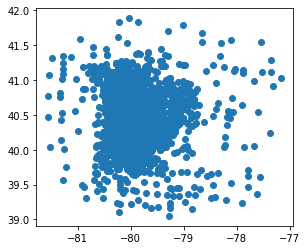

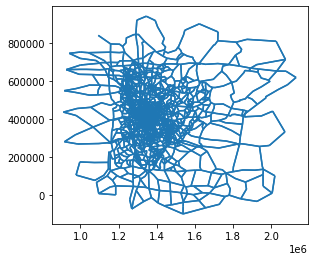

In [18]:
nodes.plot()
#nodes.crs
edges.plot()

## "Clip" the data: subset PGH road network by selected neighborhoods

In [19]:
new_dir = cwd.replace('Code', 'Data/PGH_neighborhoods/')
os.chdir(new_dir)

<AxesSubplot:>

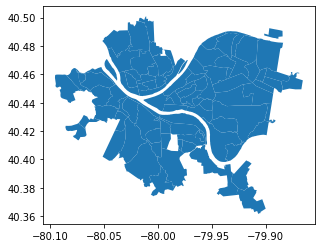

In [20]:
pgh_nhoods = read_file("Neighborhoods_.shp")   # https://data.wprdc.org/dataset/neighborhoods2
pgh_nhoods.plot()  # this is a polygon layer

In [21]:
# Select a subset of neighborhoods for which the analysis will be conducted
hood_list = pgh_nhoods['hood'].tolist()
hood_keep = [ 'Central Oakland', 'North Oakland', 'Squirrel Hill North', 'Squirrel Hill South', 'Shadyside']  # smaller list for testing
# hood_keep = ['Squirrel Hill North', 'Shadyside', 'East Liberty', "Central Oakland", 'North Oakland', 
#              'South Oakland', 'Bloomfield', 'Garfield', 'Friendship', 'East Liberty', 
#              'Larimer', 'Shadyside', 'Squirrel Hill North', 'Squirrel Hill South', 'Greenfield', 'Hazelwood', 
#              'Glen Hazel', 'Swisshelm Park', 'Point Breeze'] 
             #'Upper Hill', 'Polish Hill', 'Lower Lawrenceville',
            #'Upper Lawrenceville'] #'Westwood', 'Crafton Heights', 'Sheraden', 'Windgap', 'Fairywood']
pgh_nhoods_mask = pgh_nhoods[pgh_nhoods['hood'].isin(hood_keep)]  # subset the nhood polygon layer

104

<AxesSubplot:>

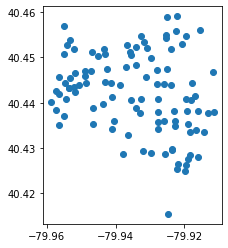

In [22]:
# clip the nodes: only include those within the selected neighborhoods
nodes_clip = gpd.clip(nodes, pgh_nhoods_mask)  
len(nodes_clip)
nodes_clip.plot()

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

354

<AxesSubplot:>

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
14934,1003206,7787,2047,25,1,0.01,0,1003206,1364430.917,405076.396,1363784.042,405223.271,"LINESTRING (-79.91995 40.42494, -79.92229 40.4..."
3900,3206,2047,7787,25,1,0.01,0,3206,1363784.042,405223.271,1364430.917,405076.396,"LINESTRING (-79.92229 40.42530, -79.91995 40.4..."
1894,2746,998,2047,25,1,0.03,0,2746+1003205,1362556.958,405333.688,1363784.042,405223.271,"LINESTRING (-79.92575 40.42546, -79.92392 40.4..."
3902,3205,2047,998,25,1,0.03,0,3205+1002746,1363784.042,405223.271,1362556.958,405333.688,"LINESTRING (-79.92229 40.42530, -79.92392 40.4..."
4107,3201,2144,7787,25,1,0.01,0,3201,1364584.042,405521.882,1364430.917,405076.396,"LINESTRING (-79.91944 40.42617, -79.91995 40.4..."


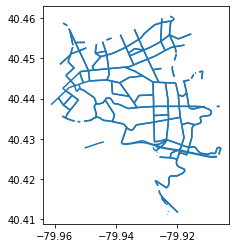

In [23]:
# The geometry of edges has a diferent coordinate ref system than the geometry of nodes and neighborhoods
# edges.crs
# pgh_nhoods_mask.crs
# nodes.crs

# Transform geometry of edges to the proper coord system
edges = edges.to_crs(epsg = 4326)
edges.crs

# Now edges can be clipped appropriately
edges_clip = gpd.clip(edges, pgh_nhoods_mask)
len(edges_clip)
edges_clip.plot()
edges_clip.head(5)

<AxesSubplot:>

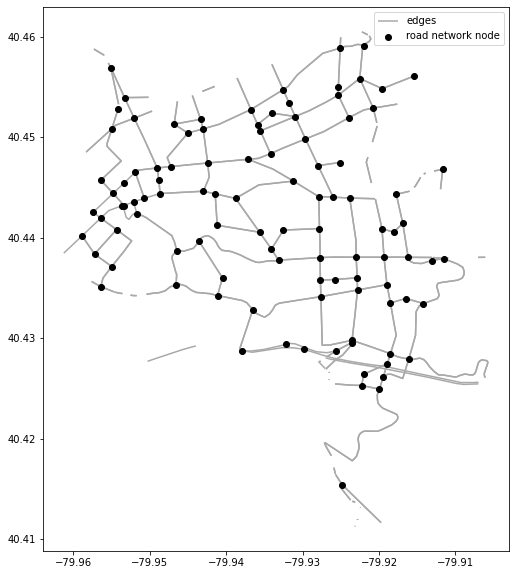

In [24]:
plot_nodes_and_edges([(nodes_clip, 'black', 'road network node')], edges_clip)

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
75,1003090,37,3461,25,2,0.05,0,1003090,1363567.25,414950.448,1361962.042,414213.990,"LINESTRING (-79.92393 40.45198, -79.92723 40.4..."
77,3097,37,727,25,2,0.02,0,3097,1363567.25,414950.448,1364456.833,415271.281,"LINESTRING (-79.92393 40.45198, -79.92196 40.4..."
76,1003094,37,2894,20,1,0.02,0,1003094,1363567.25,414950.448,1363194.022,415773.493,"LINESTRING (-79.92393 40.45198, -79.92534 40.4..."


<AxesSubplot:>

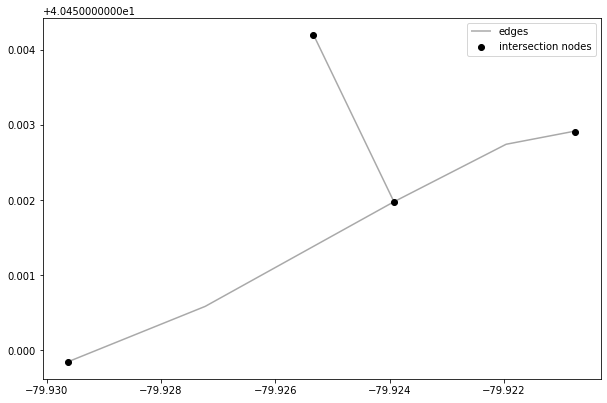

In [25]:
# Are 'N1' and 'N2' in edges df equivalent to 'ID' in nodes df? Test:
edges_clip = edges_clip.astype({'N1':'int32', 'N2':'int32', 'linkID':'int32'})
eclip_test = edges_clip[edges_clip['N1'] == 37]
eclip_test
nclip_test = nodes_clip[((nodes_clip['ID'] == 37) | (nodes_clip['ID'] == 3461) | (nodes_clip['ID'] == 2894) | (nodes_clip['ID'] == 727))]

plot_nodes_and_edges([(nclip_test, 'black', 'intersection nodes')], eclip_test)
# this plot confirms that N1 and N2 columns in edges df are equivalent to ID column in nodes df

In [26]:
nodes_clip.loc[27]['geometry'].x
nodes_clip.loc[27]['geometry'].y

-79.923923

40.451967

In [27]:
edges_clip.head(3)
# redefine the linkIDs such that they correspond to the row number. not sure if this will mess things up yet
edges_clip.reset_index(inplace=True)
edges_clip['linkID'] = edges_clip.index
edges_clip.head()

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
14934,1003206,7787,2047,25,1,0.01,0,1003206,1364430.917,405076.396,1363784.042,405223.271,"LINESTRING (-79.91995 40.42494, -79.92229 40.4..."
3900,3206,2047,7787,25,1,0.01,0,3206,1363784.042,405223.271,1364430.917,405076.396,"LINESTRING (-79.92229 40.42530, -79.91995 40.4..."
1894,2746,998,2047,25,1,0.03,0,2746+1003205,1362556.958,405333.688,1363784.042,405223.271,"LINESTRING (-79.92575 40.42546, -79.92392 40.4..."


,index,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
0,14934,0,7787,2047,25,1,0.01,0,1003206,1364430.917,405076.396,1363784.042,405223.271,"LINESTRING (-79.91995 40.42494, -79.92229 40.4..."
1,3900,1,2047,7787,25,1,0.01,0,3206,1363784.042,405223.271,1364430.917,405076.396,"LINESTRING (-79.92229 40.42530, -79.91995 40.4..."
2,1894,2,998,2047,25,1,0.03,0,2746+1003205,1362556.958,405333.688,1363784.042,405223.271,"LINESTRING (-79.92575 40.42546, -79.92392 40.4..."
3,3902,3,2047,998,25,1,0.03,0,3205+1002746,1363784.042,405223.271,1362556.958,405333.688,"LINESTRING (-79.92229 40.42530, -79.92392 40.4..."
4,4107,4,2144,7787,25,1,0.01,0,3201,1364584.042,405521.882,1364430.917,405076.396,"LINESTRING (-79.91944 40.42617, -79.91995 40.4..."


## Convert geopandas df to networkx graph
### Because the small network test code was written using the networkx graph object

In [28]:
nodes_clip.columns

Index(['ID', 'isOD', 'geometry'], dtype='object')

In [29]:
# add x-y columns for coordinates 
nodes_clip['x'] = nodes_clip.apply(lambda p: p['geometry'].x, axis=1)
nodes_clip['y'] = nodes_clip.apply(lambda p: p['geometry'].y, axis=1)
nodes_clip['nx_pos'] = nodes_clip.apply(lambda p: nx_pos(p['x'], p['y']), axis=1)
nodes_clip.columns

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Applications/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Applications/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Index(['ID', 'isOD', 'geometry', 'x', 'y', 'nx_pos'], dtype='object')

In [30]:
nodes_clip.head(3)

,ID,isOD,geometry,x,y,nx_pos
1657,2338,0,POINT (-79.92483 40.41541),-79.924826,40.415406,"{'pos': (-79.924826, 40.415406)}"
5570,7787,0,POINT (-79.91995 40.42493),-79.919949,40.424930,"{'pos': (-79.919949, 40.42493)}"
1447,2047,0,POINT (-79.92229 40.42529),-79.922285,40.425289,"{'pos': (-79.922285, 40.425289)}"


In [31]:
# add nodes to the graph, including their positions 
G_base = to_nx_graph(nodes_clip)
G_base.nodes[37]['pos']

(-79.923923, 40.451967)

In [32]:
edges_clip['attr'] = edges_clip.apply(lambda e: nx_edge_attr('speed', e['spd']), axis=1)
#edges_clip['nx_linkID'] = edges_clip.apply(lambda e: nx_edge_attr('link_ID', e['linkID']), axis=1)
#edges_clip['attr'] = edges_clip.apply(lambda e: merge(e['nx_speed'], e['nx_linkID']), axis=1)
edges_clip.head(2)

,index,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry,attr
0,14934,0,7787,2047,25,1,0.01,0,1003206,1364430.917,405076.396,1363784.042,405223.271,"LINESTRING (-79.91995 40.42494, -79.92229 40.4...",{'speed': '25'}
1,3900,1,2047,7787,25,1,0.01,0,3206,1363784.042,405223.271,1364430.917,405076.396,"LINESTRING (-79.92229 40.42530, -79.91995 40.4...",{'speed': '25'}


In [33]:
# only include edges if the nodes they connect are also in the nodes of the graph
graph_edges = prune_edges(G_base, edges_clip)
graph_edges[:3]

[(7787, 2047, {'speed': '25'}),
 (2047, 7787, {'speed': '25'}),
 (2144, 7787, {'speed': '25'})]

In [34]:
# add edges to the graph, including their speed limit
G_base.add_edges_from(graph_edges)
len(G_base.nodes)

104

Text(0.5, 1.0, 'Base Road Map for Selected Neighborhoods')

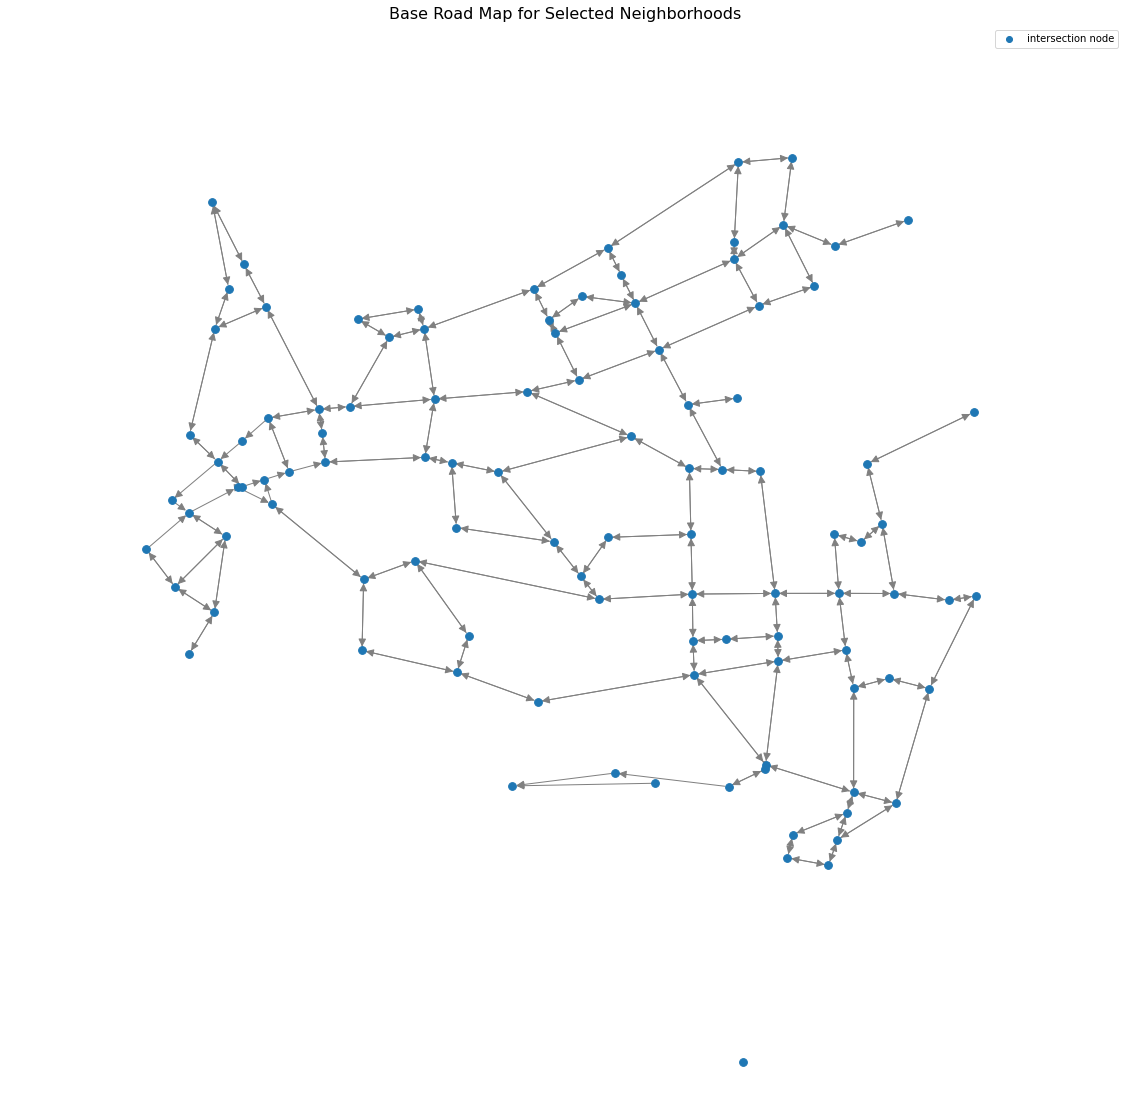

In [35]:
node_cmap = {'intersection node': '#1f77b4'}
ax = draw_graph(G_base, '#1f77b4', node_cmap, edge_color='gray')
ax.set_title('Base Road Map for Selected Neighborhoods', fontsize=16)

## TNC
The TNC graph is assumed to be the same as the base road network

In [36]:
G_tnc = G_base.copy()
G_tnc = rename_nodes(G_tnc, 't')

In [37]:
def set_link_IDs(G, prev_max_linkID):
    num_links = G.size()
    linkIDs = [i for i in range(prev_max_linkID+1, prev_max_linkID+1 + num_links)]
    a = dict(zip(G.edges, linkIDs))
    attr = {key: {'link_ID':val} for key, val in a.items()}
    nx.set_edge_attributes(G, attr)  

In [38]:
set_link_IDs(G_tnc, -1)
#test = max(list(nx.get_edge_attributes(G_tnc, 'link_ID').values()))
#test

In [215]:
#G_tnc['t5188']['t903']

## Personal Vehicle 

### Park and Ride Data

In [40]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/ParkRide')
os.chdir(new_dir)
file_name = 'SPCRegPNR.shp'   # https://data.wprdc.org/dataset/regional-park-n-ride-facilities-web-inventory/resource/46692b9c-ad3f-4a29-8deb-5ca4207eb50d
pnr_gdf = read_file(file_name)
pnr_gdf.head(2)
#pnr_gdf.crs
# Transform geometry of edges to the proper coord system
pnr_gdf = pnr_gdf.to_crs(epsg = 4326)
#pnr_gdf.crs

,ID,STATUS,NAME,LOCATION,MUNIC,ZIPCITY,ZIPCODE,COUNTY,X_COORD,Y_COORD,RESTRICT_,CAPACITY,OWNER,PARK_FEE,D_PARK_FEE,M_PARK_FEE,SERV_TRANS,TRANS_OP_1,TRANS_OP_2,geometry
0,1.0,OPEN,OLYMPIA SHOPPING CENTER-WALNUT ST-MCKEESPORT,4313 WALNUT ST.,CITY OF MCKEESPORT,MCKEESPORT,15132,ALLEGHENY,40.32270,-79.83461,TRANSIT ONLY,50,PRIVATE,NO,0.0,0.0,YES,PORT AUTHORITY OF ALLEGHENY COUNTY,NONE,POINT (1387303.979 367272.753)
1,2.0,OPEN,DUQUESNE-LIBRARY PL AT DUQUESNE BLVD-DUQUESNE,RT 837 (DUQUESNE BLVD.) AT LIBRARY PL.,CITY OF DUQUESNE,DUQUESNE,15110,ALLEGHENY,40.37227,-79.84466,NONE,311,PORT AUTHORITY OF ALLEGHENY COUNTY,NO,0.0,0.0,YES,PORT AUTHORITY OF ALLEGHENY COUNTY,NONE,POINT (1384930.811 385392.023)


Text(0.5, 1.0, 'Park and Ride facilities relative to the study area')

(0, 20)

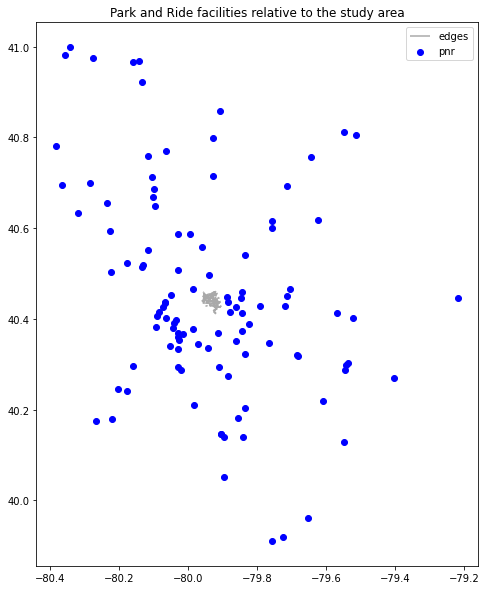

In [41]:
ax = plot_nodes_and_edges([(pnr_gdf, 'blue', 'pnr')], edges_clip)
ax.set_title('Park and Ride facilities relative to the study area')
# observe that no park and ride facilities intersect the study area...
# confirmation:
pnr_clip = gpd.clip(pnr_gdf, pgh_nhoods_mask)
pnr_clip.shape

Text(0.5, 1.0, 'Park and Ride facilities relative to the study area')

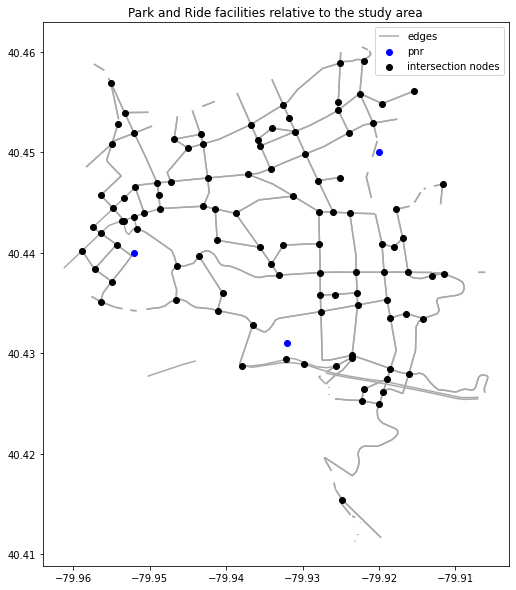

In [46]:
# for testing, i have chosen to create three fake pnr facilities located within study area
# randomly choose three nodes that are spread out in the road network
pnr1 = (-79.952, 40.44)
pnr2 = (-79.92, 40.45)
pnr3 = (-79.932, 40.431)
pnr_coords = [pnr1, pnr2, pnr3]
# build shapely Points from these coords
point_list = [Point(c[0], c[1]) for c in pnr_coords]
new_pnr_gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries(point_list), crs='EPSG:4326')
ax = plot_nodes_and_edges([(new_pnr_gdf, 'blue', 'pnr'), (nodes_clip, 'black', 'intersection nodes')], edges_clip)
ax.set_title('Park and Ride facilities relative to the study area')

### Create edges from Park and Ride stations to nearest node neighbor in the road network

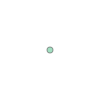

In [47]:
new_pnr_gdf['geometry'].iloc[0]

In [48]:
#from sklearn.neighbors import BallTree

In [49]:
a, b, c = near(new_pnr_gdf['geometry'][0], nodes_clip)
print(a,b,c)
new_pnr_gdf.head()
type(new_pnr_gdf)

POINT (-79.951671 40.442357) 7952 0.0023798508356643396


,geometry
0,POINT (-79.95200 40.44000)
1,POINT (-79.92000 40.45000)
2,POINT (-79.93200 40.43100)


geopandas.geodataframe.GeoDataFrame

In [50]:
# find the intersection node in the road network that is nearest to the pnr station
new_pnr_gdf[['nn_geom','nn_ID','nn_dist']] = new_pnr_gdf.apply(lambda row: near(row['geometry'], nodes_clip), axis=1).tolist()
# add attributes necessary for conversion to nx.graph
new_pnr_gdf['x'] = new_pnr_gdf['geometry'].x
new_pnr_gdf['y'] = new_pnr_gdf['geometry'].y
new_pnr_gdf['nx_pos'] = new_pnr_gdf.apply(lambda p: nx_pos(p['x'], p['y']), axis=1)
new_pnr_gdf.insert(loc=0, column='ID', value=np.arange(len(new_pnr_gdf)))
new_pnr_gdf.head()
# add linestring beween each pnr facility and its nn (for graphing)
pnr_geom_edges = [LineString([row['geometry'], row['nn_geom']]) for i, row in new_pnr_gdf.iterrows()]
pnr_edges_gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries(pnr_geom_edges), crs='EPSG:4326')
# these edges will be explicitly added to the networkx graph structure

/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: FutureWarning: The input object of type 'Point' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Point', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order)
/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,ID,geometry,nn_geom,nn_ID,nn_dist,x,y,nx_pos
0,0,POINT (-79.95200 40.44000),POINT (-79.951671 40.442357),7952,0.00238,-79.952,40.440,"{'pos': (-79.952, 40.44)}"
1,1,POINT (-79.92000 40.45000),POINT (-79.920756 40.452908),727,0.003005,-79.920,40.450,"{'pos': (-79.92, 40.45)}"
2,2,POINT (-79.93200 40.43100),POINT (-79.93214 40.429382),8286,0.001624,-79.932,40.431,"{'pos': (-79.932, 40.431)}"


Text(0.5, 1.0, 'Park and Ride facilities relative to the study area')

<AxesSubplot:title={'center':'Park and Ride facilities relative to the study area'}>

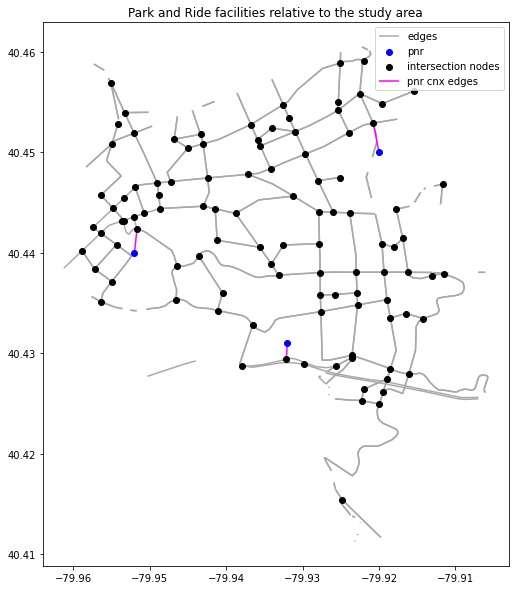

In [51]:
ax = plot_nodes_and_edges([(new_pnr_gdf, 'blue', 'pnr'), (nodes_clip, 'black', 'intersection nodes')], edges_clip)
ax.set_title('Park and Ride facilities relative to the study area')
pnr_edges_gdf.plot(ax=ax, color = 'magenta', zorder=1, label='pnr cnx edges')
ax.legend()

### Convert to networkx graph object

In [58]:
# create graph structure 
# start with base road network
G_pv = G_base.copy()
G_pv = rename_nodes(G_pv, 'pv')

In [59]:
#G_pv.edges['pv5188', 'pv903']

In [60]:
# convert pnr nodes to nx graph and then merge with road network
G_pnr = to_nx_graph(new_pnr_gdf)
G_pnr = rename_nodes(G_pnr, 'k')
G_pv = nx.union_all([G_pv, G_pnr])   # merge the intersection nodes with the pnr stations

In [61]:
# add edges from pnr station to the road map in order to connect the network
new_pnr_gdf['nodeID'] = new_pnr_gdf.apply(lambda row: 'k'+str(row['ID']), axis=1)
new_pnr_gdf['nn_nodeID'] = new_pnr_gdf.apply(lambda row: 'pv'+str(row['nn_ID']), axis=1)
edges_out = list(zip(new_pnr_gdf['nodeID'], new_pnr_gdf['nn_nodeID']))
edges_in = list(zip(new_pnr_gdf['nn_nodeID'], new_pnr_gdf['nodeID']))
G_pv.add_edges_from(edges_out + edges_in)  

In [62]:
# add link IDs
prev_max_linkID = max(list(nx.get_edge_attributes(G_tnc, 'link_ID').values()))
prev_max_linkID
set_link_IDs(G_pv, prev_max_linkID)

264

Text(0.5, 1.0, 'Personal Vehicle Network')

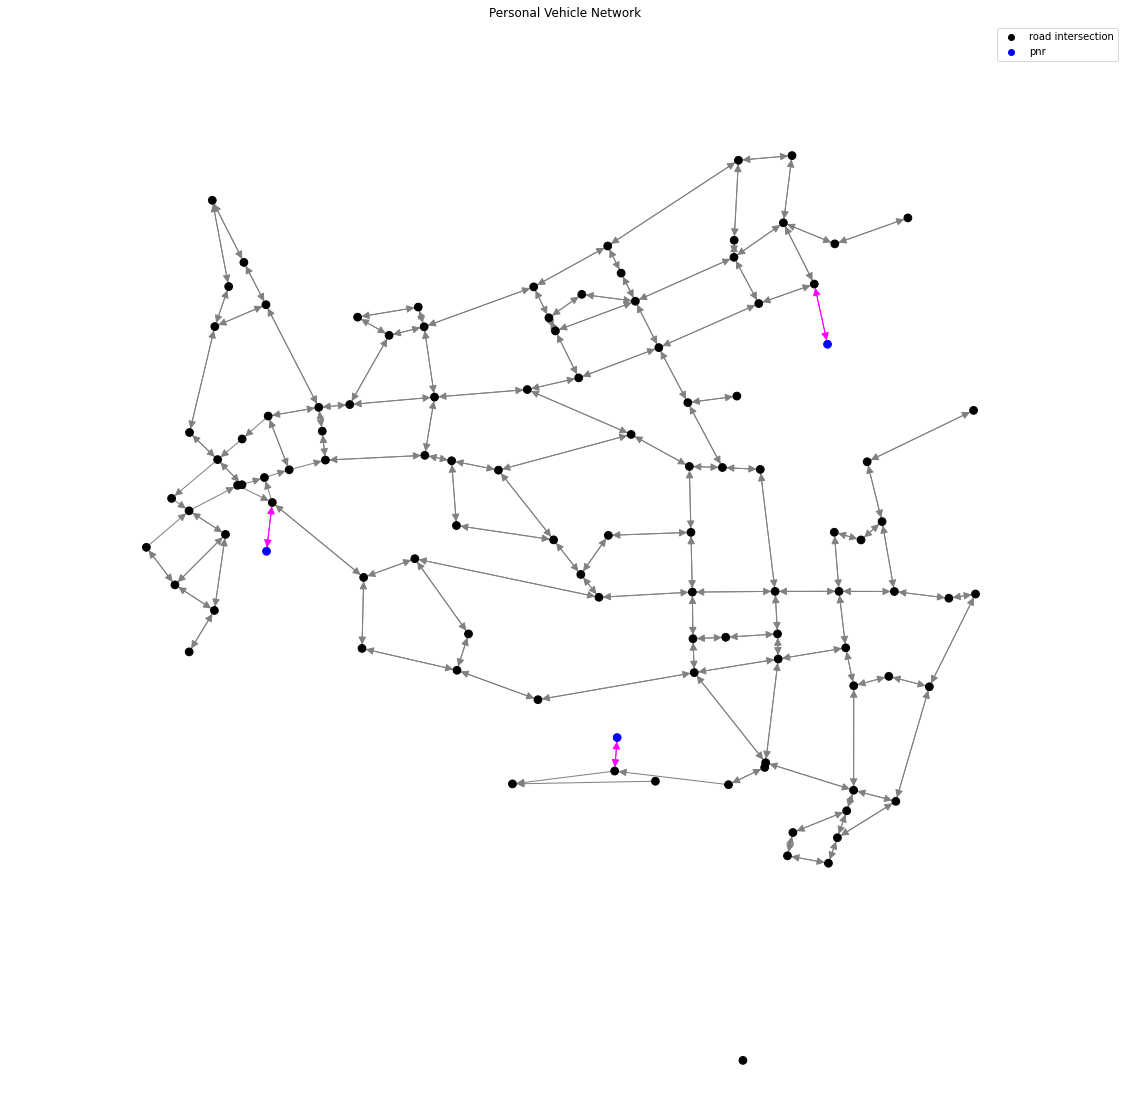

In [63]:
node_color = ['black' if n.startswith('pv') else 'blue' for n in G_pv.nodes]
edge_color = ['grey' if e[0].startswith('pv') and e[1].startswith('pv') else 'magenta' for e in G_pv.edges]
ax = draw_graph(G_pv, node_color, {'road intersection':'black', 'pnr':'blue'}, edge_color)
ax.set_title('Personal Vehicle Network')

**Summary up to this point** <br>
We began with the base road network node/link shapefile, which contained intersection nodes and road links. This was clipped to the study area of interest and converted into the networkx graph object after some data processing. The nodes have IDs and position attributes, and the links have IDs and speed limit attributes. The unimodal TNC network was taken to be an exact copy of the base road network. The personal vehicle network was then constructed as an exact copy of the base road network with two additions: 1) park + ride station nodes, and 2) park + ride connector edges. Connector edges are edges that join the station to the nearest road intersection node. It is necessary to construct these connector edges because the park and ride station nodes may not exactly intersect a road network node. It is also important to note that each unimodal network is associated with distinct node and link IDs; although the networks overlap in the physical world, they are considered unique in our model. Distinct node and link IDS are required to solve the multimodal shortest path problem.

## Personal Bike

In its simplest form, the personal bike network consists of the base road network, where only the street segments with a speed limit less than 40 mph (subject to change) are retained. We may also think about adding off-road bike paths. Furthermore, it will be useful to download the bike lane shapefile at some point, as this will be used to assess segment safety.

In [64]:
# Start with the original road network
# Then find the "bike-friendly" streets, i.e. those with a speed limit <= 40
bike_speedlim_max = 40
edges_clip['spd'] = edges_clip['spd'].astype('float')
bike_edges_clip = edges_clip[edges_clip['spd'] <= bike_speedlim_max]
edges_clip.shape
bike_edges_clip.shape  # only slight reduction in roads with a max speed limit of 40...could lower the max speed limit if desired
# Find the nodes that interesect the bike-friendly streets (in the clipped network)
nodes_keep = list(set(bike_edges_clip.N1.tolist() + bike_edges_clip.N2.tolist()))
bike_nodes_clip = nodes_clip[nodes_clip.ID.isin(nodes_keep)]
bike_edges_clip.head(2)

(354, 15)

(346, 15)

,index,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry,attr
0,14934,0,7787,2047,25.0,1,0.01,0,1003206,1364430.917,405076.396,1363784.042,405223.271,"LINESTRING (-79.91995 40.42494, -79.92229 40.4...",{'speed': '25'}
1,3900,1,2047,7787,25.0,1,0.01,0,3206,1363784.042,405223.271,1364430.917,405076.396,"LINESTRING (-79.92229 40.42530, -79.91995 40.4...",{'speed': '25'}


In [65]:
G_pb = to_nx_graph(bike_nodes_clip)
pruned_edges = prune_edges(G_pb, bike_edges_clip)
prefix = 'pb'
graph_edges = [(prefix + str(e[0]), prefix + str(e[1]), e[2]) for e in pruned_edges]
G_pb = rename_nodes(G_pb, prefix) # rename nodes
G_pb.add_edges_from(graph_edges)
# set link IDs
prev_max_linkID = max(list(nx.get_edge_attributes(G_pv, 'link_ID').values()))
set_link_IDs(G_pb, prev_max_linkID)
G_pb.size()

262

Text(0.5, 1.0, 'Personal Bike Network for Selected Neighborhoods')

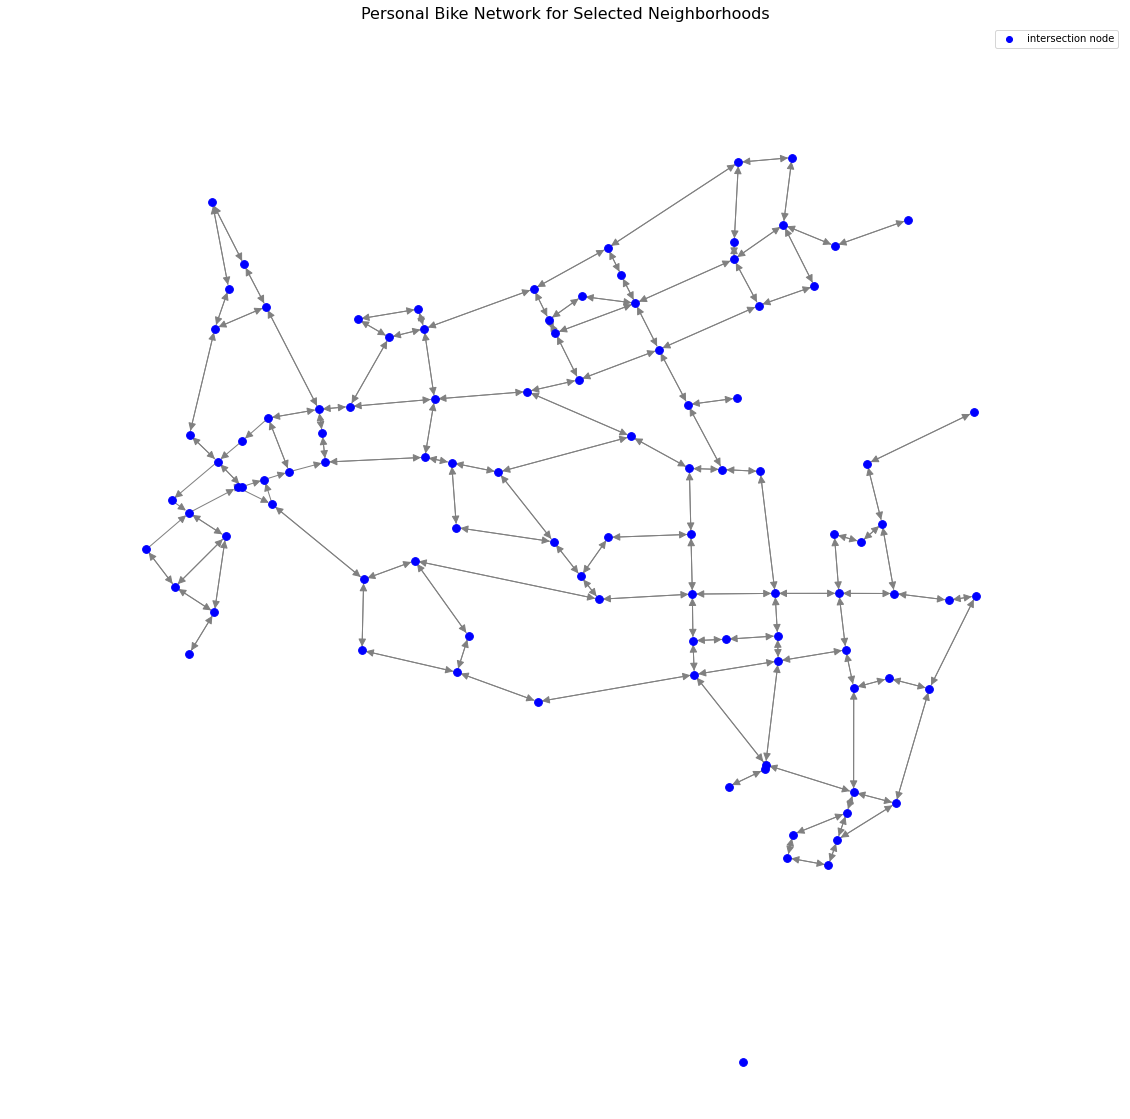

In [66]:
node_cmap = {'intersection node': 'blue'}
ax = draw_graph(G_pb, 'blue', node_cmap, edge_color='gray')
ax.set_title('Personal Bike Network for Selected Neighborhoods', fontsize=16)

## Bikeshare

**Get bikeshare Data**

In [67]:
# Healthy Ride depots:  https://data.wprdc.org/dataset/healthyride-stations

In [68]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/')
os.chdir(new_dir)
os.getcwd()

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Data'

In [69]:
filename = 'pgh_bikeshare_depot_q3_2021.csv'
bs_df = pd.read_csv(filename)
bs_df.head()

,Station #,Station Name,# of Racks,Latitude,Longitude
0,1000,Liberty Ave & Stanwix St,16,40.441326,-80.004679
1,1001,Forbes Ave & Market Square,19,40.440877,-80.003080
2,1002,Third Ave & Wood St,15,40.439030,-80.001860
3,1003,First Ave & Smithfield St,9,40.437200,-80.000375
4,1004,First Ave & B St (T Station),15,40.435887,-79.997102


In [70]:
# add position column, to be used when converting to networkx graph object
bs_df['nx_pos'] = bs_df.apply(lambda p: nx_pos(p['Longitude'], p['Latitude']), axis=1)

**Convert to geo df and clip to selected neighborhoods**

In [216]:
# generate point geometry from x,y coords, so that the GIS clip function can be used to only 
# include depots within the study region
bs_df['geometry'] = gpd.points_from_xy(bs_df.Longitude, bs_df.Latitude, crs="EPSG:4326")
bs_gdf = gpd.GeoDataFrame(bs_df)  # convert to geo df

In [72]:
# Clip the bs node network
bs_depots_clip = gpd.clip(bs_gdf, pgh_nhoods_mask)

<AxesSubplot:>

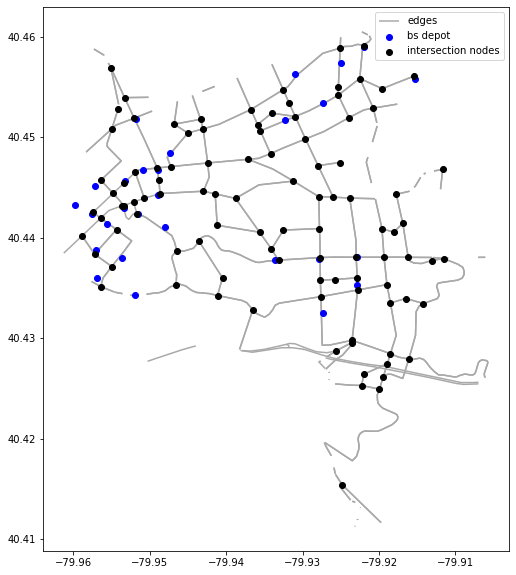

In [73]:
plot_nodes_and_edges([(bs_depots_clip, 'blue', 'bs depot'), (bike_nodes_clip, 'black', 'intersection nodes')], edges_clip)

In [74]:
# data: 
# 1) bike_nodes_clip: intersection nodes
# 2) bike_edges_clip: road nodes
# 3) bs_depots_clip: depot nodes

**Create edge from bikeshare depot to nearest network node** <br>
This is the same procedure as what was used for the park and ride stations

In [75]:
bs_depots_clip[['nn_geom', 'nn_ID', 'nn_dist']] = bs_depots_clip.apply(lambda row: near(row['geometry'], bike_nodes_clip), axis=1).tolist()
bs_depots_clip.head()
# add linestring beween each pnr facility and its nn (for graphing)
depot_cnx_edges = [LineString([row['geometry'], row['nn_geom']]) for i, row in bs_depots_clip.iterrows()]
depot_cnx_edges_gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries(depot_cnx_edges), crs='EPSG:4326')
depot_cnx_edges_gdf.head()

/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: FutureWarning: The input object of type 'Point' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Point', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order)
/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Applications/anaconda

,Station #,Station Name,# of Racks,Latitude,Longitude,nx_pos,geometry,nn_geom,nn_ID,nn_dist
37,1038,Boulevard of the Allies & Parkview Ave,19,40.434338,-79.951877,"{'pos': (-79.951877, 40.434338)}",POINT (-79.95188 40.43434),POINT (-79.954972 40.43714),3045,0.004175
43,1044,Zulema St & Coltart Ave,19,40.435986,-79.956942,"{'pos': (-79.956942, 40.435986)}",POINT (-79.95694 40.43599),POINT (-79.956411 40.43514),5354,0.000999
38,1039,Atwood St & Bates St,8,40.437987,-79.953670,"{'pos': (-79.95367, 40.437987)}",POINT (-79.95367 40.43799),POINT (-79.954972 40.43714),3045,0.001553
70,1091,Semple St & Louisa St,5,40.438749,-79.957032,"{'pos': (-79.95703161, 40.43874918)}",POINT (-79.95703 40.43875),POINT (-79.957221 40.438376),2108,0.000418
36,1037,Frew St & Schenley Dr,20,40.441032,-79.948042,"{'pos': (-79.948042, 40.441032)}",POINT (-79.94804 40.44103),POINT (-79.946459 40.438736),1320,0.002789


,geometry
0,"LINESTRING (-79.95188 40.43434, -79.95497 40.4..."
1,"LINESTRING (-79.95694 40.43599, -79.95641 40.4..."
2,"LINESTRING (-79.95367 40.43799, -79.95497 40.4..."
3,"LINESTRING (-79.95703 40.43875, -79.95722 40.4..."
4,"LINESTRING (-79.94804 40.44103, -79.94646 40.4..."


<AxesSubplot:>

Text(0.5, 1.0, 'Bikeshare Network')

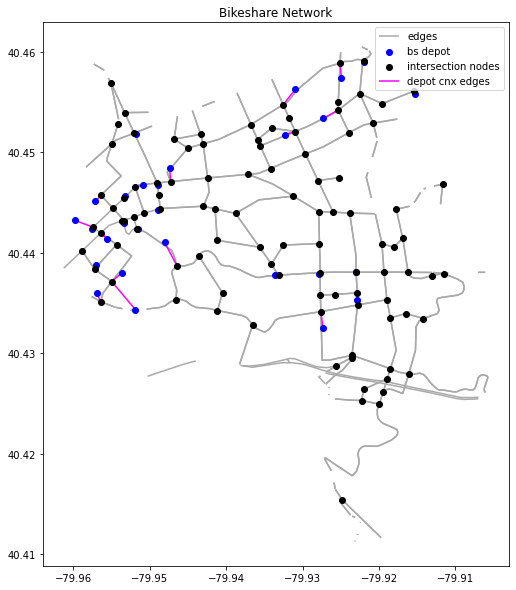

In [76]:
ax = plot_nodes_and_edges([(bs_depots_clip, 'blue', 'bs depot'), (bike_nodes_clip, 'black', 'intersection nodes')], edges_clip)
depot_cnx_edges_gdf.plot(ax=ax, color = 'magenta', zorder=1, label='depot cnx edges')
ax.set_title('Bikeshare Network')
ax.legend()

### Convert to networkx graph

In [77]:
# first add intersection nodes and rename
G_bs = G_pb.copy()  
prefix = 'bs'
G_bs = rename_nodes(G_bs, prefix)

In [78]:
bs_depots_clip.insert(0, 'ID', bs_depots_clip.apply(lambda row: 'bsd'+str(row['Station #']), axis=1))
bs_depots_clip.head(2)
depot_list = list(zip(bs_depots_clip.ID, bs_depots_clip.nx_pos))
depot_list[:2]

,ID,Station #,Station Name,# of Racks,Latitude,Longitude,nx_pos,geometry,nn_geom,nn_ID,nn_dist
37,bsd1038,1038,Boulevard of the Allies & Parkview Ave,19,40.434338,-79.951877,"{'pos': (-79.951877, 40.434338)}",POINT (-79.95188 40.43434),POINT (-79.954972 40.43714),3045,0.004175
43,bsd1044,1044,Zulema St & Coltart Ave,19,40.435986,-79.956942,"{'pos': (-79.956942, 40.435986)}",POINT (-79.95694 40.43599),POINT (-79.956411 40.43514),5354,0.000999


[('bsd1038', {'pos': (-79.951877, 40.434338)}),
 ('bsd1044', {'pos': (-79.956942, 40.435986)})]

In [79]:
# then add depot nodes with IDs
G_bs.add_nodes_from(depot_list)

# add the depot cnx edges
bs_depots_clip['nn_nodeID'] = bs_depots_clip.apply(lambda row: 'bs'+str(row['nn_ID']), axis=1)
edges_out = list(zip(bs_depots_clip['ID'], bs_depots_clip['nn_nodeID']))
edges_in = list(zip(bs_depots_clip['nn_nodeID'], bs_depots_clip['ID']))
G_bs.add_edges_from(edges_out + edges_in)  

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [80]:
# add link IDs
prev_max_linkID = max(list(nx.get_edge_attributes(G_pb, 'link_ID').values()))
prev_max_linkID
set_link_IDs(G_bs, prev_max_linkID)

797

In [81]:
G_bs.size()
G_pb.size() + len(bs_depots_clip) * 2  # this checks out

318

318

**This is the graph that will be used to find precomputed edge weights of shortcut edges between depot nodes**

Text(0.5, 1.0, 'Bikeshare Network')

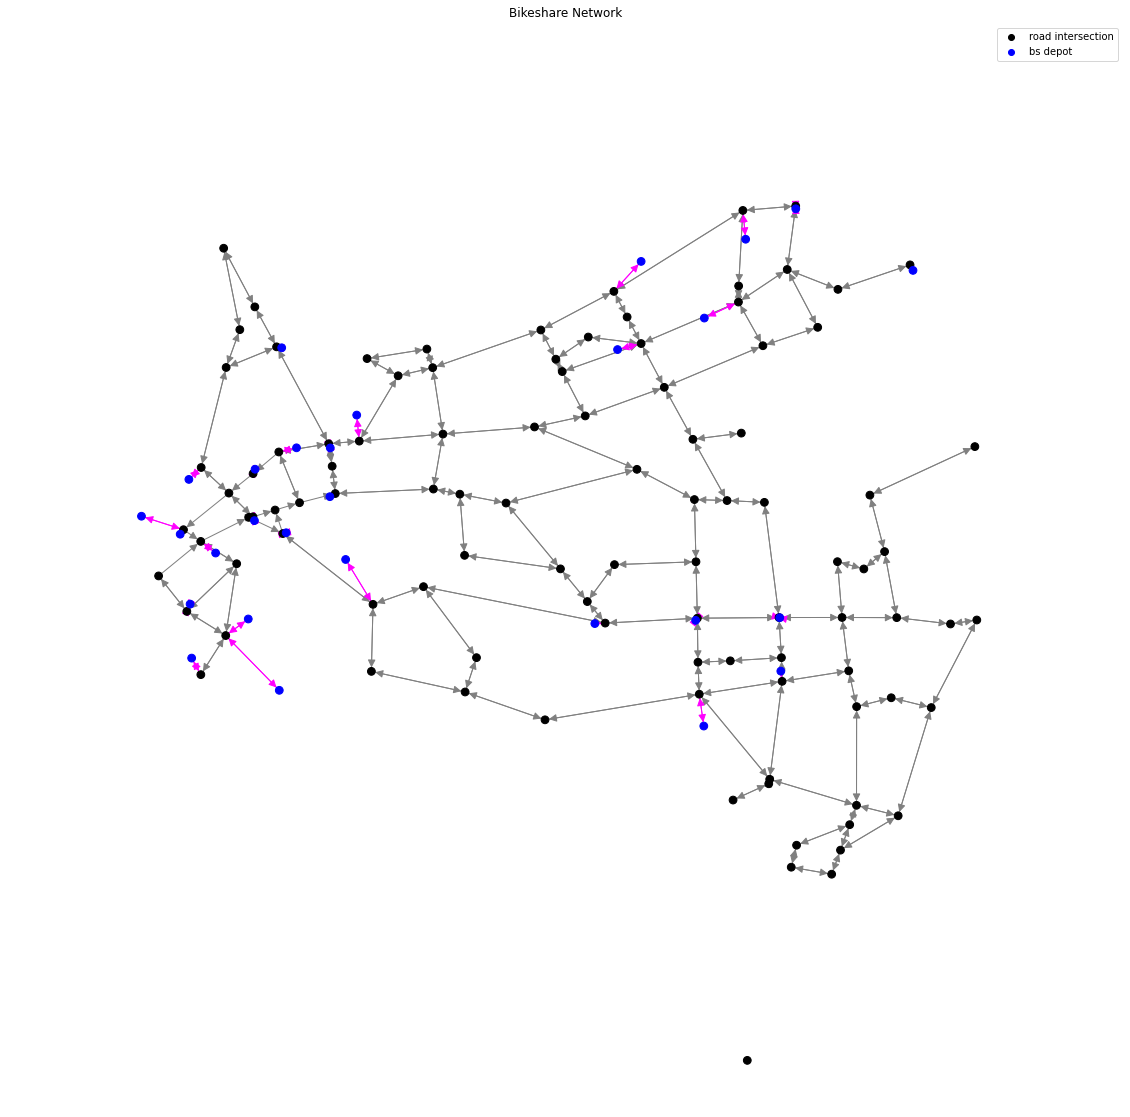

In [82]:
node_color = ['blue' if n.startswith('bsd') else 'black' for n in G_bs.nodes]
edge_color = ['magenta' if (e[0].startswith('bsd') or e[1].startswith('bsd')) else 'gray' for e in G_bs.edges]
ax = draw_graph(G_bs, node_color, {'road intersection':'black', 'bs depot':'blue'}, edge_color)
ax.set_title('Bikeshare Network')
# TO DO: add legend for edge color. See small network for example

### Precompute the bikeshare network

This is the graph that will be used in the supernetwork

<AxesSubplot:>

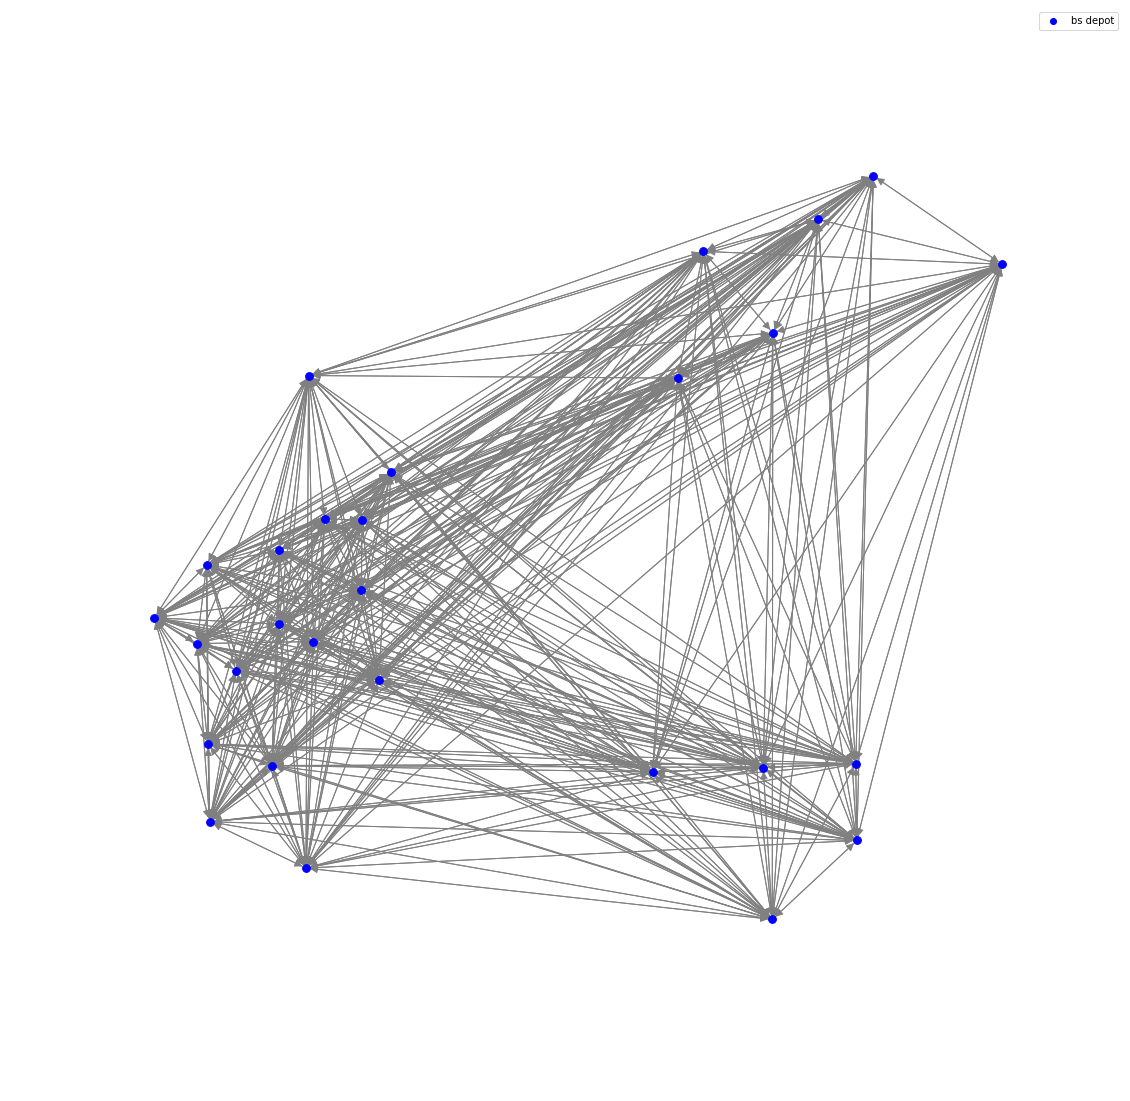

In [102]:
G_bs_pre = to_nx_graph(bs_depots_clip)  # only include depots
G_bs_pre = rename_nodes(G_bs_pre, 'bs')

bs_depot_pairs = list(itertools.permutations(list(G_bs_pre.nodes), 2))
# Add shortcut b/w all depot edges. Don't calculate shortcut edge weight yet; will be done in subsequent step
for e in bs_depot_pairs:
    G_bs_pre.add_edge(*e)
draw_graph(G_bs_pre, 'blue', {'bs depot': 'blue'}, 'gray')

In [103]:
print('Number of shortcut edges = ', (len(G_bs_pre.nodes)*(len(G_bs_pre.nodes)-1)))
len(G_bs_pre.edges)  # checks out

Number of shortcut edges =  756


756

In [104]:
# add link IDs
prev_max_linkID = max(list(nx.get_edge_attributes(G_pb, 'link_ID').values()))
prev_max_linkID
set_link_IDs(G_bs_pre, prev_max_linkID)

797

In [105]:
G_bs_pre.nodes

NodeView(('bs1038', 'bs1044', 'bs1039', 'bs1091', 'bs1037', 'bs1093', 'bs1041', 'bs1070', 'bs1069', 'bs49251', 'bs49261', 'bs1068', 'bs1033', 'bs1032', 'bs1028', 'bs1036', 'bs1095', 'bs1099', 'bs1040', 'bs1097', 'bs49271', 'bs1035', 'bs1034', 'bs49301', 'bs1031', 'bs1029', 'bs1027', 'bs1094'))

**To do: use base bikeshare network to precompute edge cost for shortcut bikeshare network**

## Public Transit

GTFS data was processed in Public_Transit_Data.ipynb. Here we read the processed data.

In [85]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/PortAuthority/GTFS/')
os.chdir(new_dir)
filename = 'PT_route_data.csv'   

In [86]:
os.getcwd()

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Data/PortAuthority/GTFS'

In [87]:
pt_df = pd.read_pickle(filename)  # read file
pt_df.columns = ['route_id', 'direction_id', 'stop_sequence', 'point_sequence']
pt_df['geometry'] = pt_df['point_sequence'].apply(lambda x: LineString(x))  # add linestring data for routing
pt_gdf = gpd.GeoDataFrame(pt_df, crs='EPSG:4326')  # convert to gdf 
pt_gdf_clip = gpd.clip(pt_gdf, pgh_nhoods_mask)  # clip to study area
pt_gdf_clip.head()

,route_id,direction_id,stop_sequence,point_sequence,geometry
63,53L,0,"[43, 10147, 12177, 11669, 12178, 12180, 12181,...","[POINT (-80.004786 40.439575), POINT (-80.0035...","MULTILINESTRING ((-79.94983 40.42841, -79.9480..."
64,53L,1,"[21187, 20906, 21465, 9616, 21224, 21225, 2122...","[POINT (-79.93244199999999 40.361767), POINT (...","MULTILINESTRING ((-79.91966 40.41168, -79.9229..."
61,52L,0,"[43, 10147, 12177, 11669, 12178, 12180, 12181,...","[POINT (-80.004786 40.439575), POINT (-80.0035...","MULTILINESTRING ((-79.94983 40.42841, -79.9480..."
175,P7,0,"[22296, 8778, 15284, 15285, 20287, 16107, 2050...","[POINT (-80.002082 40.441802), POINT (-80.0002...","MULTILINESTRING ((-79.95646 40.45837, -79.9539..."
81,61A,0,"[20856, 1664, 20293, 3241, 3242, 20976, 20977,...","[POINT (-80.000658 40.440792), POINT (-79.9988...","MULTILINESTRING ((-79.96121 40.43844, -79.9595..."


<AxesSubplot:>

Text(0.5, 1.0, 'Single Route and Associated Stops, superimposed over study area')

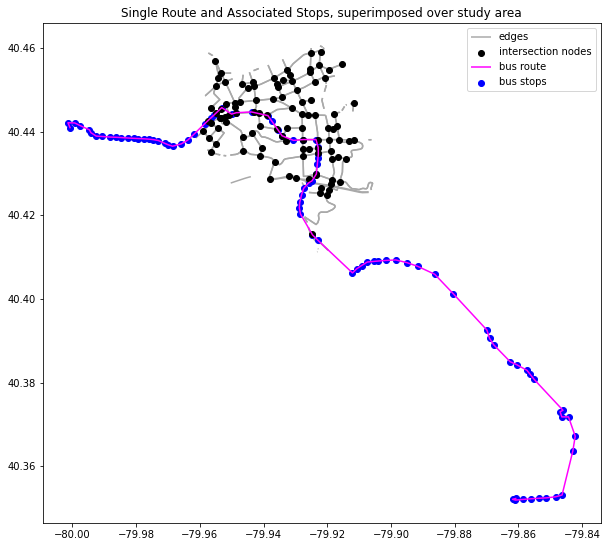

In [88]:
# Testing: 
temp = pt_gdf.loc[(pt_gdf.route_id == '61C') & (pt_gdf.direction_id == 1)]
#fig, ax = plt.subplots(figsize=(10,10))
ax = plot_nodes_and_edges([(nodes_clip, 'black', 'intersection nodes')], edges_clip)
temp.plot(ax=ax, zorder=2, color='magenta', label='bus route')
xs = [point.x for point in temp['point_sequence'].values[0]]
ys = [point.y for point in temp['point_sequence'].values[0]]
ax.scatter(xs, ys, color='blue', label = 'bus stops')
ax.legend()
ax.set_title('Single Route and Associated Stops, superimposed over study area')

### Convert to networkx graph

**Nodes**

In [106]:
# first we need the coordinates of all the bus stops 
# we will ues the stops.txt file directly from GTFS
stops_df = pd.read_csv('stops.txt')
stops_df.head(3)

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,4875,4875,ARLINGTON AVE + FREDERICK,NaN,40.417694,-79.982614,01,NaN,NaN,NaN,NaN,0
1,4876,4876,ARLINGTON AVE + KOEHLER,NaN,40.417637,-79.984507,01,NaN,NaN,NaN,NaN,0
2,4877,4877,ARLINGTON AVE + S 18TH,NaN,40.417582,-79.986232,01,NaN,NaN,NaN,NaN,0


In [107]:
stops_df['nx_pos'] = stops_df.apply(lambda p: nx_pos(p['stop_lon'], p['stop_lat']), axis=1)
stops_df['ID'] = stops_df['stop_id']
stops_df['geometry'] = gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat, crs='EPSG:4326')
stops_gdf = gpd.GeoDataFrame(stops_df, crs='EPSG:4326')
stops_gdf_clip = gpd.clip(stops_gdf, pgh_nhoods_mask)
len(stops_gdf_clip.stop_id.unique())

306

306

<AxesSubplot:>

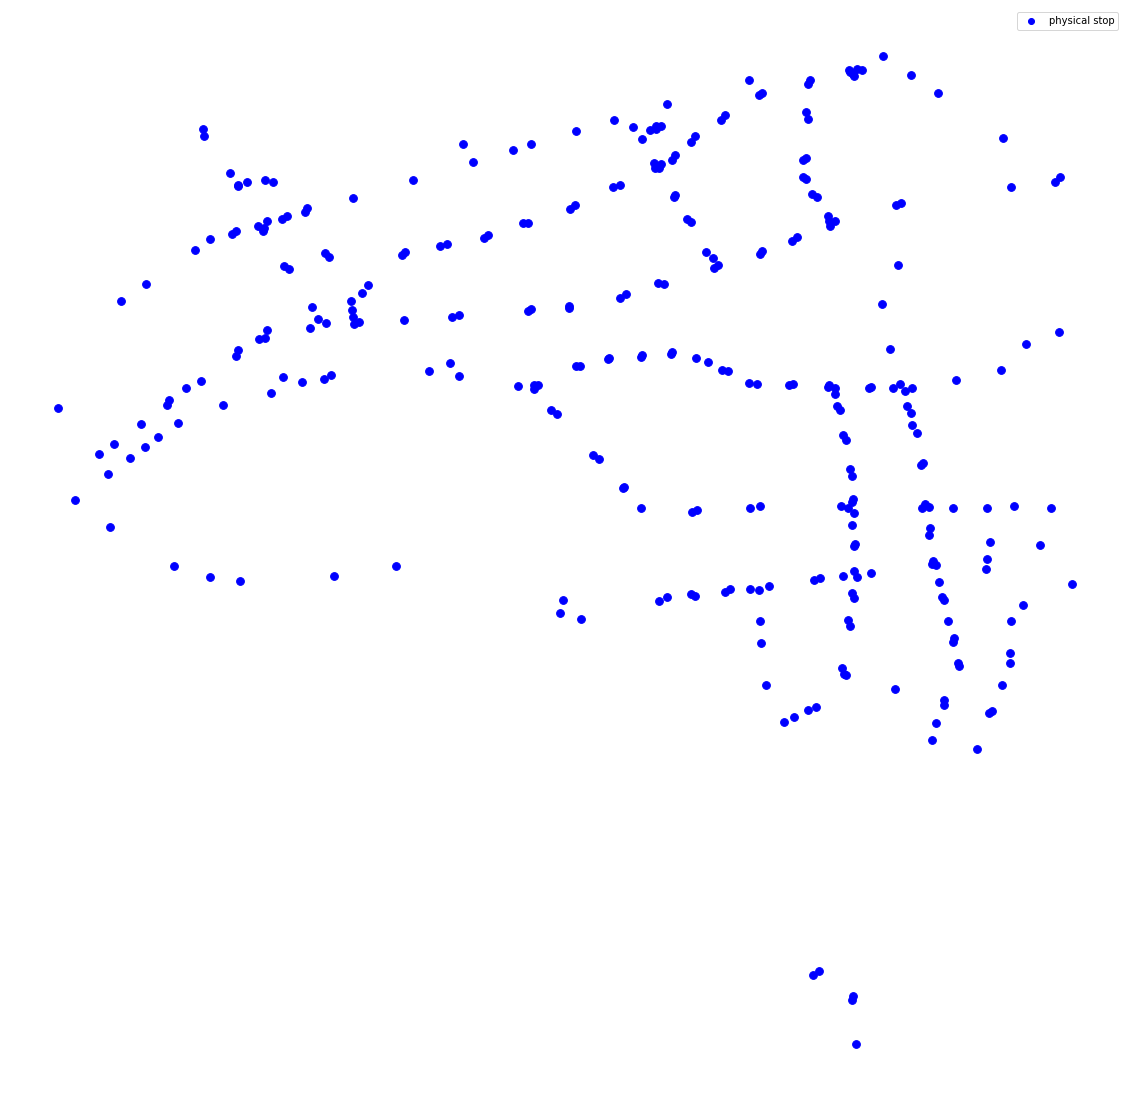

In [157]:
G_pt = to_nx_graph(stops_gdf_clip)
G_pt = rename_nodes(G_pt, 'ps')
len(list(G_pt.nodes))
draw_graph(G_pt, 'blue', {'physical stop':'blue'}, 'grey')

In [217]:
# construct an "offset geometry" for route nodes (for visualization purposes, so that route nodes do not exactly
# overlap physical stop nodes)
stops_gdf_clip['offset_geom'] = stops_gdf_clip['geometry'].translate(0.001, 0.001)
rt_nodes_gdf = stops_gdf_clip[['ID', 'offset_geom']].rename(columns={'offset_geom':'geometry'})
rt_nodes_gdf['x'] = rt_nodes_gdf['geometry'].apply(lambda p: p.x)
rt_nodes_gdf['y'] = rt_nodes_gdf['geometry'].apply(lambda p: p.y)
rt_nodes_gdf['nx_pos'] = rt_nodes_gdf.apply(lambda p: nx_pos(p['x'], p['y']), axis=1) 
rt_nodes_gdf.head()
G_rt = to_nx_graph(rt_nodes_gdf)
G_rt = rename_nodes(G_rt, 'rt')

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,ID,geometry,x,y,nx_pos
2919,18458,POINT (-79.92393 40.41609),-79.923930,40.416093,"{'pos': (-79.92393, 40.416093)}"
5112,10913,POINT (-79.92362 40.41632),-79.923617,40.416316,"{'pos': (-79.923617, 40.416315999999995)}"
5505,12123,POINT (-79.92180 40.41270),-79.921799,40.412704,"{'pos': (-79.921799, 40.412704)}"
5143,10959,POINT (-79.92198 40.41487),-79.921983,40.414866,"{'pos': (-79.921983, 40.414865999999996)}"
4440,19375,POINT (-79.92197 40.41506),-79.921971,40.415065,"{'pos': (-79.921971, 40.415065)}"


In [159]:
len(list(G_rt.nodes))
G_pt = nx.union_all([G_pt, G_rt])
len(list(G_pt.nodes))  # checks out

306

612

In [160]:
# G_pt.nodes['ps1189']
# G_pt.nodes['rt1189']

In [161]:
# now we need to add route nodes
# # we will replicate the physical stops 
# G_rt = G_pt.copy()
# #len(list(G_rt.nodes))
# G_rt = rename_nodes(G_rt, 'rt')  
# G_pt = nx.union_all([G_pt, G_rt])
# len(list(G_pt.nodes))  # checks out

In [162]:
# add a node attribute for the bus route(s) that pass through the stop node 
filename = 'stops_routes_dir.csv'  # this file was created in Public_Transit_Data.ipynb
stops_routes_dir_df = pd.read_pickle(filename)  # read file
stops_routes_dir_df['nx_routes'] = stops_routes_dir_df.apply(lambda x: {'routes': x['route_dir_id']}, axis=1)
stops_routes_dir_df['ps_id'] = 'ps' + stops_routes_dir_df['stop_id']
stops_routes_dir_df['rt_id'] = 'rt' + stops_routes_dir_df['stop_id']
stops_routes_dir_df['geometry'] = gpd.points_from_xy(stops_routes_dir_df['stop_lon'], stops_routes_dir_df['stop_lat'])
stops_routes_dir_gdf = gpd.GeoDataFrame(stops_routes_dir_df, crs='EPSG:4326')
stops_routes_dir_clip_gdf = gpd.clip(stops_routes_dir_gdf, pgh_nhoods_mask)  # clip the dataset
stops_routes_dir_clip_gdf.shape
stops_routes_dir_clip_gdf.head()

# add attributes
attr = dict(zip(stops_routes_dir_clip_gdf['ps_id'], stops_routes_dir_clip_gdf['nx_routes']))
nx.set_node_attributes(G_pt, attr)
attr = dict(zip(stops_routes_dir_clip_gdf['rt_id'], stops_routes_dir_clip_gdf['nx_routes']))
nx.set_node_attributes(G_pt, attr)

(306, 8)

,stop_id,stop_lat,stop_lon,route_dir_id,nx_routes,ps_id,rt_id,geometry
5828,7999,40.434269,-79.912188,"[65_1, 65_0]","{'routes': ['65_1', '65_0']}",ps7999,rt7999,POINT (-79.91219 40.43427)
646,12123,40.411704,-79.922799,[57_0],{'routes': ['57_0']},ps12123,rt12123,POINT (-79.92280 40.41170)
204,10959,40.413866,-79.922983,"[57_0, 61C_0, 53L_0, 64_0, 52L_0, 61D_0]","{'routes': ['57_0', '61C_0', '53L_0', '64_0', ...",ps10959,rt10959,POINT (-79.92298 40.41387)
2276,19375,40.414065,-79.922971,"[52L_1, 53L_1, 61C_1, 57_1, 61D_1, 64_1]","{'routes': ['52L_1', '53L_1', '61C_1', '57_1',...",ps19375,rt19375,POINT (-79.92297 40.41407)
1926,18458,40.415093,-79.924930,[57_0],{'routes': ['57_0']},ps18458,rt18458,POINT (-79.92493 40.41509)


Now for each node, we know its position as well as which route-dir pairs run through it
This will be important when building transfer edges and deconstructing the shortest path

In [163]:
#pt_gdf_clip.reset_index(inplace=True)

**Edges**

In [164]:
# add route edges
for s in pt_gdf_clip['stop_sequence']:   # s is a sequential list of nodes
    potential_edges = list(zip(s[:len(s)], s[1:len(s)+1]))
    # here we check if both edge nodes are within the study area
    edges = []
    for edge in potential_edges:
        if (('rt'+edge[0] not in list(G_pt.nodes)) | ('rt'+edge[1] not in list(G_pt.nodes))):
            continue
        else:
            edges.append(edge) 
    # give route nodes the route prefix
    rt_edges = [('rt'+e[0], 'rt'+e[1]) for e in edges]
    G_pt.add_edges_from(rt_edges)

In [165]:
# check
len(G_pt.nodes) 

612

In [166]:
# add boarding and alighting edges
ba_edges = []
for n in list(G_pt.nodes):
    if n.startswith('ps'):
        e_board = (n, 'rt'+re.sub('\D', '', n))    # re.sub('\D', '', string) removes letters from string
        e_alight = ('rt'+re.sub('\D', '', n), n)
        ba_edges.extend([e_board, e_alight])
ba_edges[:6]
G_pt.add_edges_from(ba_edges)

len(ba_edges)

[('ps18458', 'rt18458'),
 ('rt18458', 'ps18458'),
 ('ps10913', 'rt10913'),
 ('rt10913', 'ps10913'),
 ('ps12123', 'rt12123'),
 ('rt12123', 'ps12123')]

612

**Draw the graph, nodes and route edges included** <br>
Confirm that traversal edges run between route nodes boarding/alighting edges run between physical stops and virtual stops

<AxesSubplot:>

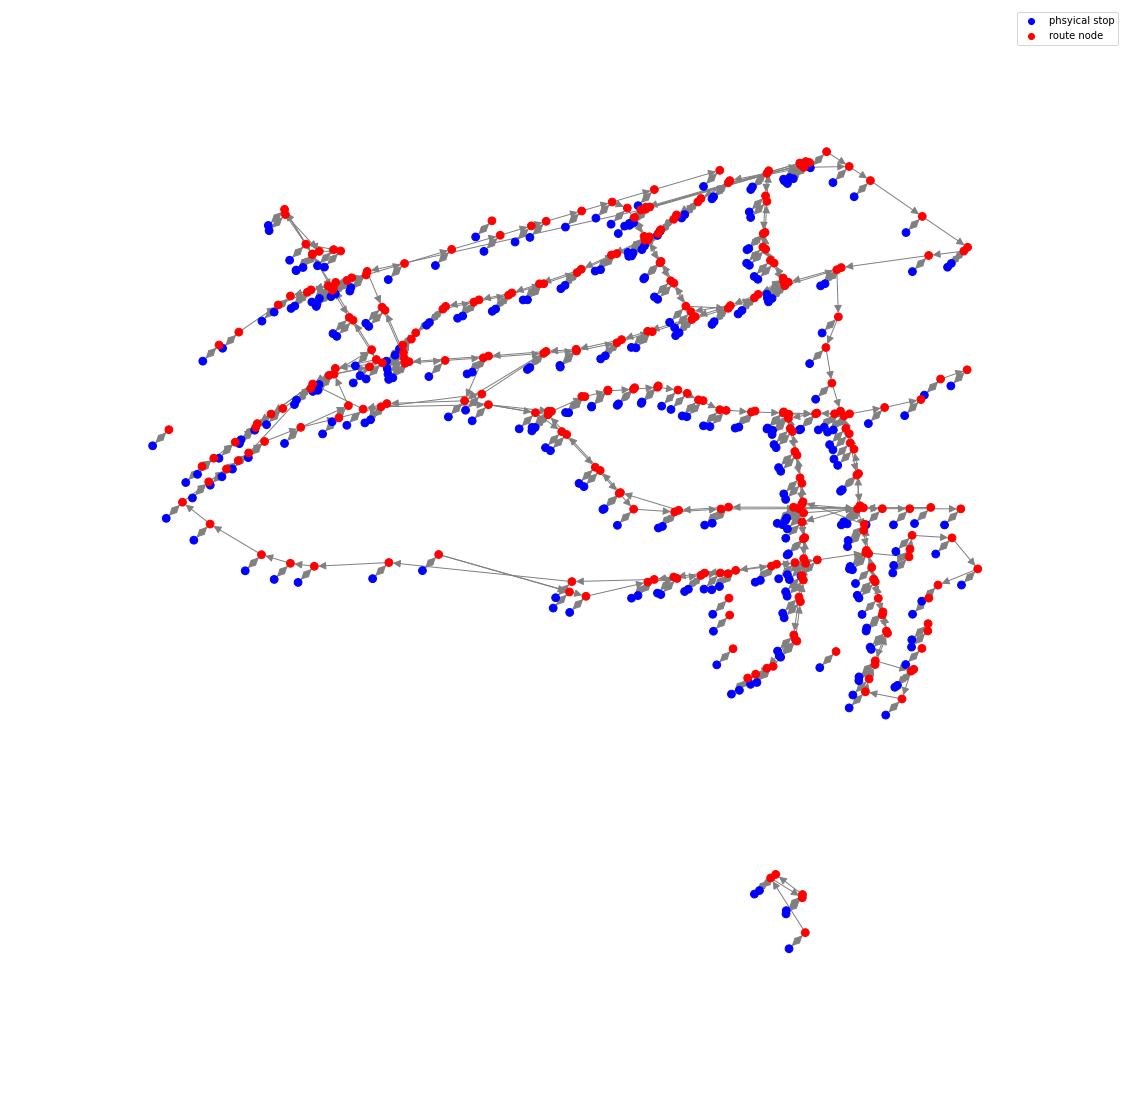

In [167]:
node_color = ['blue' if n.startswith('ps') else 'red' for n in G_pt.nodes]
node_cmap = {'phsyical stop':'blue', 'route node':'red'}
draw_graph(G_pt, node_color, node_cmap, 'gray')

In [169]:
# Now that the boarding/alighting/route edges are confirmed, maybe go back and recreate the PT graph such that 
# route nodes overlap with physical stop nodes>

In [170]:
# add link IDs
prev_max_linkID = max(list(nx.get_edge_attributes(G_bs_pre, 'link_ID').values()))
prev_max_linkID
set_link_IDs(G_pt, prev_max_linkID)

1553

In [171]:
len(G_pt.edges)

897

## Scooter

In [172]:
G_sc = G_pb.copy()
G_sc = rename_nodes(G_sc, 'sc')

In [173]:
# add link IDs
prev_max_linkID = max(list(nx.get_edge_attributes(G_pt, 'link_ID').values()))
prev_max_linkID
set_link_IDs(G_sc, prev_max_linkID)

2450

**To do: generate historical scooter location data, to be used in assignment of transfer edge costs**

# Build the supernetwork

In [174]:
# this dict defines which graphs correspond to each mode type 
all_graphs_dict = {'bs':G_bs_pre, 'pt':G_pt, 't':G_tnc, 'pv':G_pv, 'pb':G_pb, 'sc':G_sc}
# this dict defines the node names corresponding to each mode type 
all_modes_nodes = {'bs':['bs'], 'pt':['ps','rt'], 't':['t'], 'sc':['sc'], 'pv':['pv','k'], 'pb':['pb']}  

In [175]:
# define which nodes are fixed and which come from flexible networks 
all_fix_pre = ['bs','ps','k']  # prefix for fixed nodes
all_flex_pre = ['t', 'pb', 'pv', 'sc']  # prefix for flexible dropoff nodes

### Choose which networks to include in the supernetwork 

In [176]:
# this list is the parameter that defines which modes to include in the supernetwork
modes_included = ['bs','pt','t','sc','pv']   # omit the personal bike network since we are included pv and tnc

In [177]:
# this dict defines which modes and nodes are included in the supernetwork
modes_nodes_included = {k:v for k,v in all_modes_nodes.items() if k in modes_included}

networks_included = [all_graphs_dict[m] for m in modes_included]  # set([all_graphs_dict[m] for m in modes_included])

# prefixes for fixed nodes in the supernetwork
fix_pre = [n for nodes in modes_nodes_included.values() for n in nodes if n in all_fix_pre]
# prefixes for flex nodes in the supernetwork
flex_pre = [n for nodes in modes_nodes_included.values() for n in nodes if n in all_flex_pre]
print('fixed nodes included = ', fix_pre)
print('flex nodes included = ', flex_pre)

fixed nodes included =  ['bs', 'ps', 'k']
flex nodes included =  ['t', 'sc', 'pv']


## Combine the unimodal networks 

In [178]:
# combine all the graphs together into one supernetwork
G_u = nx.union_all(networks_included)

In [213]:
def node_color_list(G):
    node_color = []
    for n in G.nodes:
        if n.startswith('ps'):
            node_color.append('blue')
        if n.startswith('rt'):
            node_color.append('dimgray')
        if n.startswith('sc'):
            node_color.append('darkcyan')
        if n.startswith('bs'):
            node_color.append('green')
        if n.startswith('t'):
            node_color.append('red')
        if n.startswith('pv'):
            node_color.append('purple')
        if n.startswith('k'):
            node_color.append('black')    
    return node_color

Text(0.5, 1.0, 'Supernetwork (selected networks superimposed)')

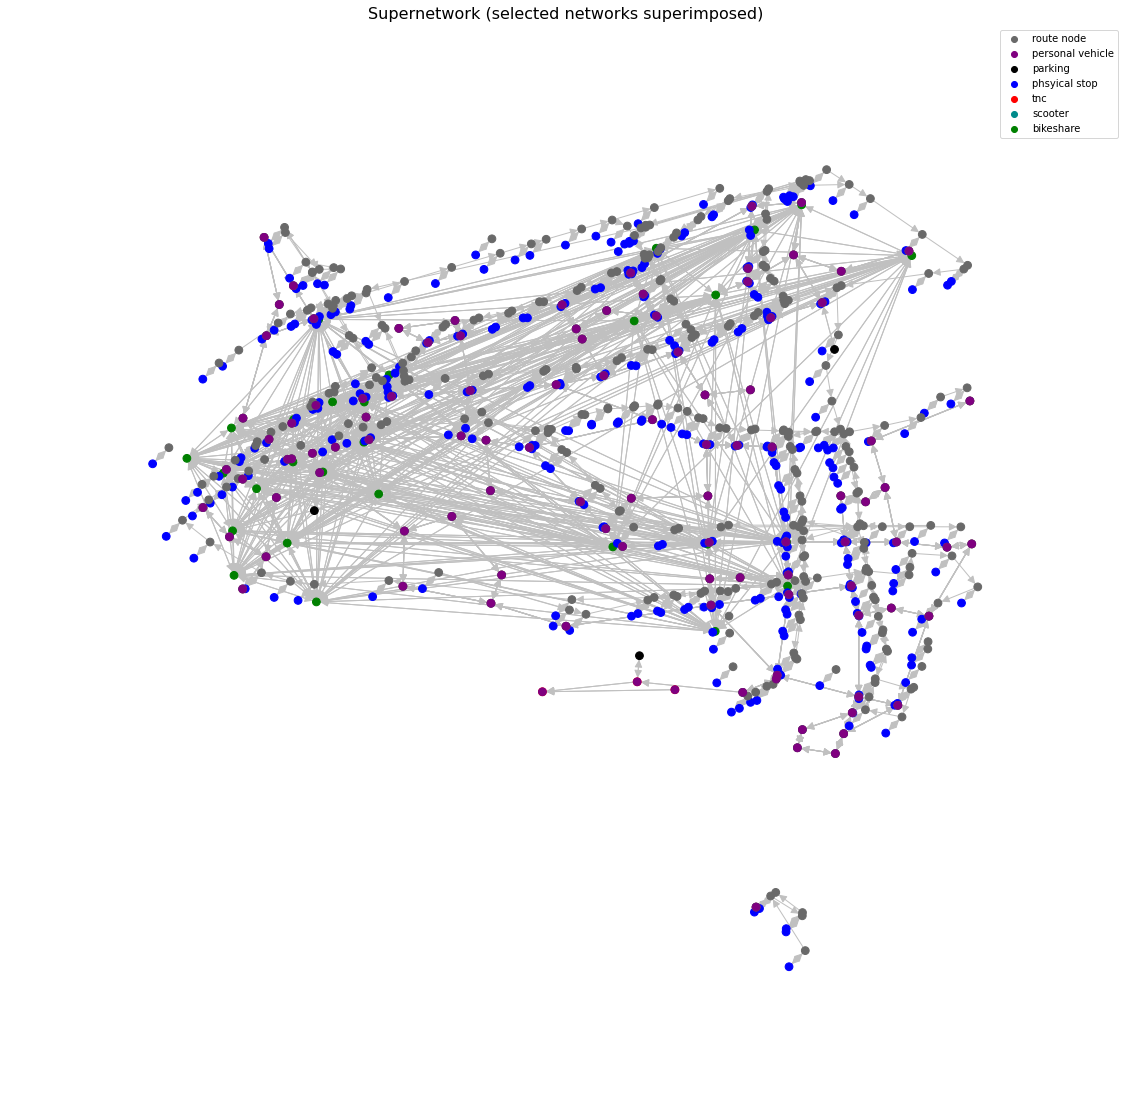

In [218]:
node_cmap = {'phsyical stop':'blue', 'route node':'dimgray', 'scooter':'darkcyan', 'bikeshare':'green',
             'tnc':'red', 'personal vehicle':'purple', 'parking':'black'}
node_color = node_color_list(G_u)
ax = draw_graph(G_u, node_color, node_cmap, 'silver')
ax.set_title('Supernetwork (selected networks superimposed)', fontsize=16)
# as expected, the networks overlap

In [184]:
# Let's adjust the supernetwork to see if it still looks right

In [199]:
# input: graph and jitter parameter (how much to adjust the x and y coordinates)
# output: adjusted graph with jittered coordinates
# this function is only for visualization purposes. the original coordinates should remain unchanged
def jitter_nodes(G, jitter_param):
    #G_adj = G.copy()
    j = jitter_param
    # adjust the nodes positions in the copy 
    for node in G.nodes.keys():
        #print(G_tnc.nodes[node]['pos'])
        adj_x = G.nodes[node]['pos'][0] + jitter_param
        #print(adj_x)
        adj_y = G.nodes[node]['pos'][1] + jitter_param
        #print(adj_y)
        nx.set_node_attributes(G, {node: {'pos':(adj_x, adj_y)}})
    return G

In [200]:
modes_included = ['t', 'bs', 'pt', 'sc', 'pv']
all_graphs_dict

{'bs': <networkx.classes.digraph.DiGraph at 0x7fa378b08490>,
 'pt': <networkx.classes.digraph.DiGraph at 0x7fa378d296d0>,
 't': <networkx.classes.digraph.DiGraph at 0x7fa392f791f0>,
 'pv': <networkx.classes.digraph.DiGraph at 0x7fa376ed3d00>,
 'pb': <networkx.classes.digraph.DiGraph at 0x7fa375554970>,
 'sc': <networkx.classes.digraph.DiGraph at 0x7fa37f700cd0>}

In [207]:
# problem is that tnc, pb, and pv intersections overlap. 
# define and adjusted graph for drawing purposes; not the real graph in physical world

# the TNC graph is the reference graph for drawing since it is the basic road network; # it will remain in its original position 
adjusted_mode_dict = {}   #{'t': G_tnc}
  
# adjust the graphs in the supernetwork using the jitter function
# this is strictly for plotting
for j, m in enumerate(modes_included):  
    #if m != 't':  # tnc graph is the "base" road network so it will not be adjusted
    G_adj = all_graphs_dict[m].copy()
    jitter_nodes(G_adj, jitter_param=(j/100)*2)  # first graph (tnc) will not be adjusted, which is appropriate since it's the basemap
    adjusted_mode_dict[m] = G_adj

Text(0.5, 1.0, 'Supernetwork, where phsyically overlapping networks are offset')

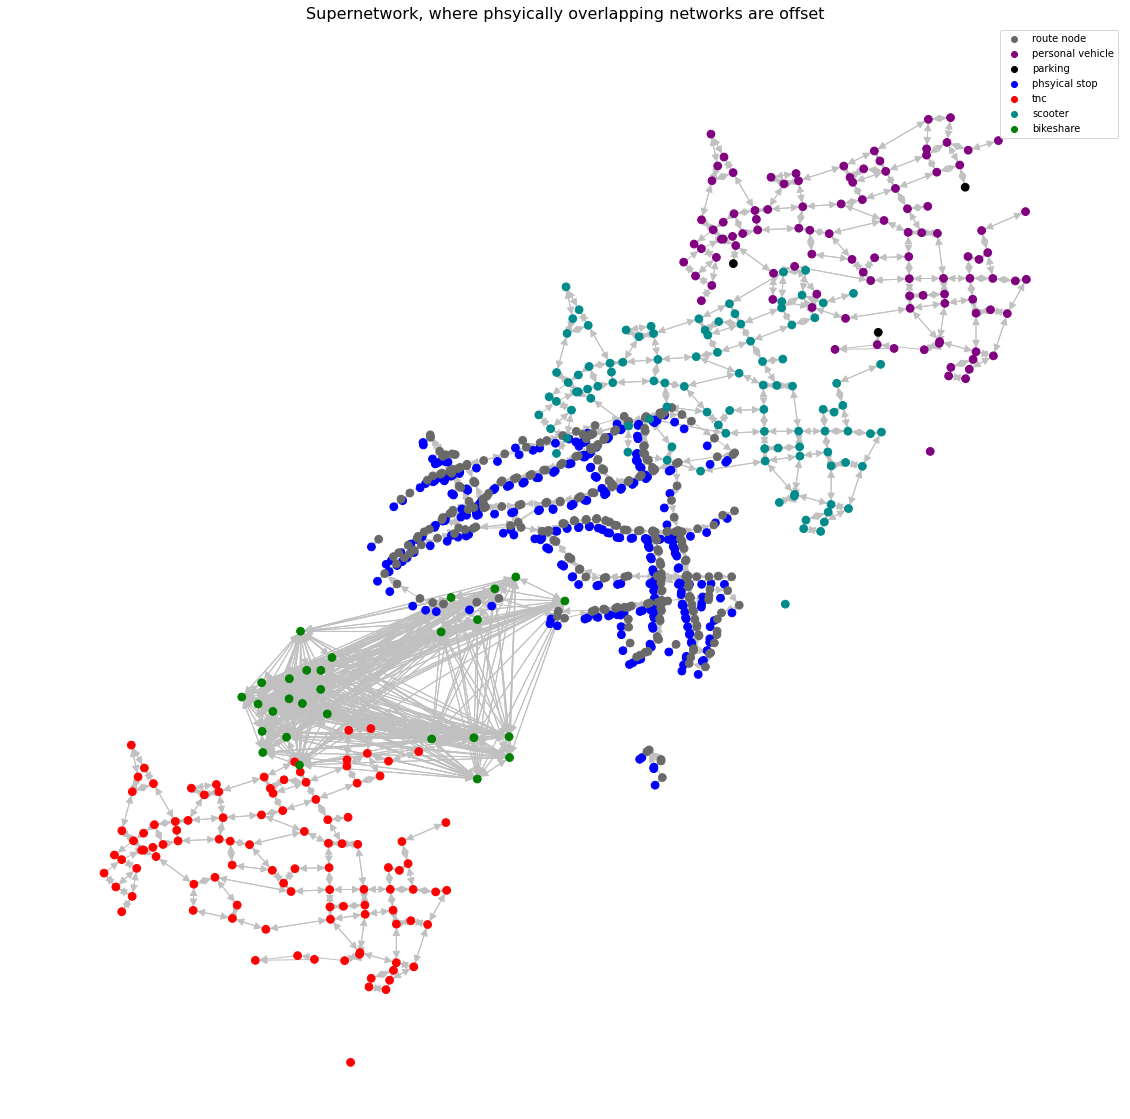

In [219]:
G_u_adj = nx.union_all(G for G in adjusted_mode_dict.values()) 
node_color = node_color_list(G_u_adj)
ax = draw_graph(G_u_adj, node_color, node_cmap, 'silver')
ax.set_title('Supernetwork, where phsyically overlapping networks are offset', fontsize=16)

**TO DO:** <br>
1. Consolidate bikeshare graph by precomputation
    1. Dependency: Add FIFO random edge cost function, then run shortest path
1. **COMPLETE** Add public tranit unimodal graph
1. **COMPLETE** Add scooter unimodal graph
1. **COMPLETE** Construct supernetwork
1. **COMPLETE** Visualize plain supernetwork as well as offset supernetwork (where individual network nodes are slightly offset)
1. Add random time-dependent edge costs (first-in-first-out random edge cost function)
1. Generate fake historical scooter location data
1. Once all unimodal networks are included, add transfer edges
1. Then OD connector edges
1. Run shortest path